In [1]:
import os, sys
os.environ['PYTHONHASHSEED']=str(0)
import random
random.seed(0)
import numpy as np
np.random.seed(0)
import tensorflow as tf
tf.set_random_seed(0)

import pandas as pd
import matplotlib.pyplot as plt
import pickle
import itertools
import time
import itertools
from IPython.display import display, clear_output
import glob

from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import SimpleRNN
from keras.initializers import glorot_uniform
from keras import optimizers

from keras.optimizers import Adam
from keras.models import load_model
from keras.callbacks import ModelCheckpoint
from keras.callbacks import Callback

from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

from keras.datasets import mnist
from keras.layers import Input, Dense
from keras.models import Model
from keras.callbacks import TensorBoard
from keras.layers import Conv2D, MaxPooling2D, UpSampling2D
from keras.models import Model
from keras import backend as K


%config InlineBackend.figure_format = 'retina'
%matplotlib inline
%load_ext autoreload
%autoreload 2

Using TensorFlow backend.


In [2]:
VERSION = '01'

try:
    import google.colab
    from google.colab import drive

    drive.mount('/content/gdrive', force_remount=True)
    root_path = 'gdrive/My Drive/Colab Notebooks/PNXS/'
    print('Working on google colab')
except:
    root_path = '../'
    print('Working locally')

directory= f'{root_path}models/{VERSION}'
if not os.path.exists(directory):
    os.makedirs(directory)    
    
# sys.path.append(f'{root_path}/rsc/{VERSION}')

# from load_data import load_data
# from pre_process_data import pre_process_data
# from create_model import create_model, print_version
# from helper import play_bell, LossHistory, add_grid_and_save
# from train_model import train_model
# from run_training import run_training
# from parameter_space import Parameter_space


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive
Working on google colab


## Hyperparameters setting

In [0]:
def create_grid(params={}):
    
    grid_file_path = '{}/model_data/grid_{}.pkl'.format(root_path, VERSION)
    
    if os.path.isfile(grid_file_path):
        grid_df = pd.read_pickle(grid_file_path)
        test_index = grid_df['test_index'].max() + 1
    else:
        test_index = 0

    current_grid = {
        'version'                : ['str'     , VERSION],
        'params'                 : ['O'       , params],
        'test_index'             : [np.int    , test_index],
        'root_path'              : ['str'     , root_path],
        'GPU'                    : [np.int    , 1],
        
        
        # Outputs
        'best_model_paths'       : ['O'       , []],
        'best_model_accuracies'  : ['O'       , []],
        'fit_outs'               : ['O'       , []]}

    for key, value in params.items():
        current_grid[key][1] = value
    return current_grid

In [0]:
xray_path = f'{root_path}data/original/train/*'
mask_path = f'{root_path}data/masked/masks/*'
xray_files = sorted(glob.glob(xray_path))[-19::-1]
mask_files = sorted(glob.glob(mask_path))[-19::-1]

import random
random.seed(42)


c = list(zip(xray_files, mask_files))
random.shuffle(c)
xray_files, mask_files = zip(*c)


X_train_files = xray_files[:32*250]
y_train_files = mask_files[:32*250]

X_test_files = xray_files[32*250:32*(80+250)]
y_test_files = mask_files[32*250:32*(80+250)]

In [26]:
import tqdm
data_len = len(X_train_files)
imgs = []
for index in tqdm.tqdm_notebook(range(1000)):
    imgs.append(img_to_array(load_img(X_train_files[index%333], color_mode='grayscale'))/255.)
    
len(imgs)

1000

In [33]:
root_path

'gdrive/My Drive/Colab Notebooks/PNXS/'

In [0]:
import h5py

with h5py.File(f'{root_path}name-of-file.h5', 'w') as hf:
    hf.create_dataset("name-of-dataset",  data=np.array(imgs))


In [0]:
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array




def create_train_generator(train_files, target_files, batch_size):
    data_len = len(train_files)
    assert(len(target_files) == data_len), 'train-target data number mismatch'
    
    print(f'Creating generator from {data_len} samples')
    
    index = 0
    while True:
        data_train = np.zeros([batch_size, 256, 256, 1])
        data_target = np.zeros([batch_size, 256, 256, 1])

        for i in range(batch_size):
            img_train = img_to_array(load_img(train_files[index%data_len], color_mode='grayscale'))/255.
            data_train[i, ...] = img_train
          
            img_target = img_to_array(load_img(target_files[index%data_len], color_mode='grayscale'))/255.
            data_target[i, ...] = img_target
            
            index = index +1
            
        data_train = data_train * np.ones([batch_size, 256, 256, 3])
        data_target = data_target
        yield data_train, data_target

In [0]:
# a = next(train_generator)
# a[0][0].shape

In [0]:
# for a in range(2):
#     i, o = next(train_generator)
#     plt.imshow(i[0][:,:,2].reshape(256, 256), cmap='bone')
#     plt.imshow(o[0][:,:,0].reshape(256, 256), alpha=0.5)
#     plt.show()

In [4]:
from keras.applications import VGG16

conv_base = VGG16(weights = 'imagenet',
                  include_top = False,
                  input_shape = (256, 256, 3))

conv_base.trainable=False

W0628 09:01:01.833935 139755881293696 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0628 09:01:01.836336 139755881293696 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0628 09:01:01.842126 139755881293696 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.



KeyboardInterrupt: ignored

In [0]:
# conv_base.summary()

In [0]:
from keras import models


doctor_model = models.Sequential()
doctor_model.add(conv_base)

doctor_model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
doctor_model.add(UpSampling2D((16,16)))
# doctor_model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
# doctor_model.add(UpSampling2D((4,4)))
doctor_model.add(Conv2D(1, (3, 3), activation='relu', padding='same'))
doctor_model.add(UpSampling2D((2,2)))

doctor_model.summary()

In [187]:
333-250

83

In [0]:
xray_path = f'{root_path}data/original/train/*'
mask_path = f'{root_path}data/masked/masks/*'
xray_files = sorted(glob.glob(xray_path))[-19::-1]
mask_files = sorted(glob.glob(mask_path))[-19::-1]

import random
random.seed(42)


c = list(zip(xray_files, mask_files))
random.shuffle(c)
xray_files, mask_files = zip(*c)


X_train_files = xray_files[:32*250]
y_train_files = mask_files[:32*250]

X_test_files = xray_files[32*250:32*(80+250)]
y_test_files = mask_files[32*250:32*(80+250)]



train_generator = create_train_generator(train_files=X_train_files, target_files=y_train_files, batch_size=32)
test_generator = create_train_generator(train_files=X_test_files, target_files=y_test_files, batch_size=32)


doctor_model.compile(loss='binary_crossentropy',
                    optimizer=optimizers.RMSprop(lr=2e-5))
outs = []

In [207]:
out = doctor_model.fit_generator(train_generator,
                                 steps_per_epoch = 250,
                                 epochs=1,
                                 validation_data = test_generator,
                                 validation_steps = 80)

outs.append(out)

Epoch 1/1
Creating generator from 2560 samples
Creating generator from 8000 samples
  5/250 [..............................] - ETA: 48:00 - loss: 0.0413

KeyboardInterrupt: ignored

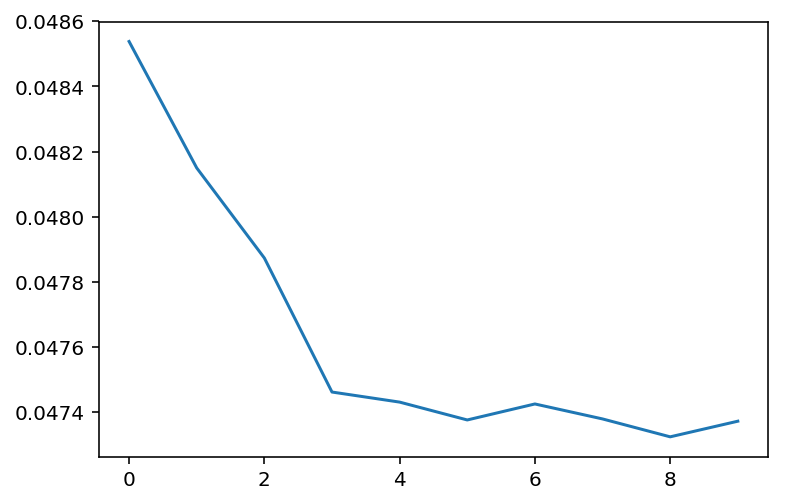

In [157]:


losses = []

for out in outs:
    for loss in out.history['loss']:
        losses.append(loss)
        
plt.plot(losses)

In [0]:
a, b = next(train_generator)


In [0]:
img = a[0][:,:,:]
y = doctor_model.predict(a);
# img.shape

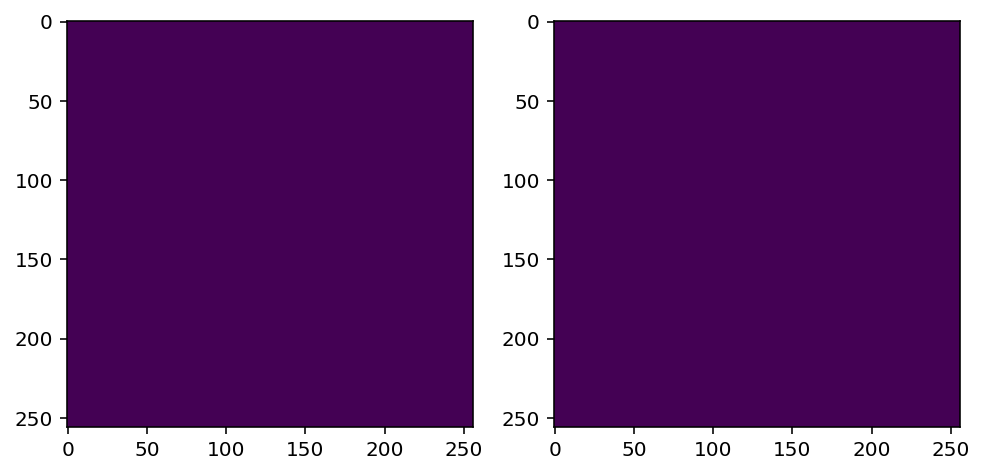

In [179]:
i=6

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))
ax1.imshow(y[i, :, :, 0])
ax2.imshow(b[i, :, :, 0])



In [137]:
%%time
conv_base.predict(a[0])
pass

ValueError: ignored

In [10]:
xray_path = f'{root_path}data/original/train/*'
mask_path = f'{root_path}data/masked/masks/*'
xray_files = sorted(glob.glob(xray_path))[-19::-1]
mask_files = sorted(glob.glob(mask_path))[-19::-1]
len(mask_files)

10657

In [0]:
import tqdm
import time



def create_train_generator_test(train_files, target_files, batch_size):
    data_len = len(train_files)
    assert(len(target_files) == data_len), 'train-target data number mismatch'
    
    print(f'Creating generator from {data_len} samples')
    
    index = 0
    while True:
        data_train = np.zeros([batch_size, 256, 256, 1])
        data_target = np.zeros([batch_size, 256, 256, 1])

        for i in range(batch_size):
            t0 = time.time()
            img_train = img_to_array(load_img(train_files[index%data_len], color_mode='grayscale'))/255.
            data_train[i, ...] = img_train
          
            img_target = img_to_array(load_img(target_files[index%data_len], color_mode='grayscale'))/255.
            data_target[i, ...] = img_target
            
            if (time.time()-t0)>0.01:
                print(f'{index} - {time.time()-t0} - {train_files[index%data_len]}')
            
            index = index +1
            
        data_train = data_train * np.ones([batch_size, 256, 256, 3])
        data_target = data_target
        yield data_train, data_target
        
        

random.seed(16)
xray_path = f'{root_path}data/original/train/*'
mask_path = f'{root_path}data/masked/masks/*'
xray_files = sorted(glob.glob(xray_path))[-19::-1]
mask_files = sorted(glob.glob(mask_path))[-19::-1]

c = list(zip(xray_files, mask_files))
random.shuffle(c)
xray_files, mask_files = zip(*c)


X_train_files = xray_files[:32*250]
y_train_files = mask_files[:32*250]

X_test_files = xray_files[32*250:32*(80+250)]
y_test_files = mask_files[32*250:32*(80+250)]
        
train_generator = create_train_generator_test(train_files=X_train_files, target_files=y_train_files, batch_size=32)


In [16]:
%%time


for i in tqdm.tqdm_notebook(range(333)):
    a, b = next(train_generator)
    pass

Creating generator from 8000 samples
0 - 0.03388333320617676 - gdrive/My Drive/Colab Notebooks/PNXS/data/original/train/1.2.276.0.7230010.3.1.4.8323329.2873.1517875175.161772.png
23 - 0.011172294616699219 - gdrive/My Drive/Colab Notebooks/PNXS/data/original/train/1.2.276.0.7230010.3.1.4.8323329.13225.1517875244.222612.png
35 - 0.8371326923370361 - gdrive/My Drive/Colab Notebooks/PNXS/data/original/train/1.2.276.0.7230010.3.1.4.8323329.10051.1517875221.752712.png
36 - 1.1496469974517822 - gdrive/My Drive/Colab Notebooks/PNXS/data/original/train/1.2.276.0.7230010.3.1.4.8323329.512.1517875163.263758.png
37 - 0.8440067768096924 - gdrive/My Drive/Colab Notebooks/PNXS/data/original/train/1.2.276.0.7230010.3.1.4.8323329.31721.1517875156.468688.png
38 - 0.6219592094421387 - gdrive/My Drive/Colab Notebooks/PNXS/data/original/train/1.2.276.0.7230010.3.1.4.8323329.14174.1517875250.117291.png
39 - 1.1475114822387695 - gdrive/My Drive/Colab Notebooks/PNXS/data/original/train/1.2.276.0.7230010.3.1.4

KeyboardInterrupt: ignored

In [240]:
%%time 
a, b = next(train_generator)

StopIteration: ignored